<a href="https://colab.research.google.com/github/pttrilok/practical_deep_learning/blob/master/Lesson%2012%20(Computer%20Vision).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this module we are going to learn about NLP From Scratch: Classifying Names with a Character-Level RNN

We will be following steps

1.   Objective
2.   Getting dataset and extracting the dataset
3.   Creating Network
4.   Training
5.   Plotting the results
6.   Making predictions on our own data

7.   Using an encoder and concept of average pooling





# ***Objective***

We will be building and training a basic character-level RNN to classify
words. This tutorial, along with the following two, show how to do
preprocess data for NLP modeling "from scratch", in particular not using
many of the convenience functions of `torchtext`, so you can see how
preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:





# Getting dataset and extracting the dataset

***Downloading dataset***

In [3]:
!wget "https://download.pytorch.org/tutorial/data.zip"

--2020-09-02 03:08:49--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.106, 99.86.38.96, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2020-09-02 03:08:50 (32.6 MB/s) - ‘data.zip’ saved [2882130/2882130]



***Extracting data***

In [4]:
!unzip "*.zip"

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


# Data Preprocessing

***Importing required Libraries......***

In [44]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

***Defining findFiles function to explore different files***

In [45]:
def findFiles(path):
  return glob.glob(path)

In [46]:
print(findFiles('data/names/*.txt'))

['data/names/Chinese.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Greek.txt', 'data/names/Vietnamese.txt', 'data/names/Spanish.txt', 'data/names/German.txt', 'data/names/Polish.txt', 'data/names/Scottish.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Arabic.txt']


***Getting all characters***

In [47]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


Turn a Unicode string to plain ASCII

In [48]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [49]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [50]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(all_categories)

['Chinese', 'Korean', 'English', 'Czech', 'Japanese', 'Dutch', 'Portuguese', 'Russian', 'Greek', 'Vietnamese', 'Spanish', 'German', 'Polish', 'Scottish', 'French', 'Irish', 'Italian', 'Arabic']


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [51]:
print(category_lines['Arabic'][:5])

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




***Importing torch....***

In [52]:
import torch

***Find letter index from all_letters, e.g. "a" = 0***

In [53]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [19]:
letterToIndex('A')

26

In [54]:
letterToIndex('a')

0

***Turning  a letter into a <1 x n_letters> Tensor(Just to Show you demo)***

In [55]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [56]:
letterToTensor("b")

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

***Turn a line into a `<line_length x 1 x n_letters>`,
 or an array of one-hot letter vectors***

In [57]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [58]:
print(lineToTensor('trilok'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

# Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

![](https://i.imgur.com/Z2xbySO.png)
   





In [59]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [30]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)
print(next_hidden)

tensor([[-2.7624, -3.0159, -2.9030, -2.8909, -2.8707, -2.8093, -2.9695, -2.8474,
         -2.8541, -2.9689, -2.7861, -2.9477, -2.8655, -2.9170, -2.8283, -2.8823,
         -2.9692, -2.9828]], grad_fn=<LogSoftmaxBackward>)
tensor([[ 5.9005e-02,  4.2900e-02,  1.2338e-01, -9.3427e-02, -5.9397e-02,
          9.7216e-02,  1.7563e-02, -1.0645e-01,  5.8129e-02,  1.3947e-01,
         -3.4592e-02,  8.4063e-02,  2.4172e-02, -2.5560e-02,  6.9173e-02,
          6.8740e-02, -4.3824e-02, -3.4685e-02,  3.7915e-02,  6.5556e-02,
         -2.3449e-04, -7.3030e-03, -5.9424e-02, -4.7288e-02,  2.5935e-02,
          3.6065e-02, -5.7277e-02, -4.9250e-03,  1.2608e-03,  6.7201e-02,
          4.5236e-02, -5.4777e-02,  1.6563e-02, -3.6030e-02, -4.3406e-04,
         -1.5537e-02, -8.9211e-02, -6.8415e-02,  9.3295e-02, -9.3448e-02,
          2.4106e-03,  1.2231e-02, -1.0875e-01,  5.1818e-02,  1.5605e-02,
          1.2862e-01,  3.6164e-02, -7.5184e-03, -6.8399e-02,  2.4227e-02,
          2.2471e-02,  1.1824e-01,  3.9

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [60]:
input = lineToTensor('Alb')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9007, -2.9353, -2.8738, -2.9811, -2.8554, -2.7746, -2.9635, -2.8634,
         -2.8325, -3.0334, -2.8985, -2.8265, -2.8544, -2.8395, -2.8928, -2.8597,
         -2.9167, -2.9593]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




# Training


***Preparing for Training***
--------------------------


Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [61]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 5)


We will also want a quick way to get a training example (a name and its
language):




In [62]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Porto
category = Polish / line = Jaskulski
category = Italian / line = Turati
category = Chinese / line = Qing
category = Scottish / line = Mccallum
category = Czech / line = Matejka
category = English / line = Edmundson
category = Arabic / line = Fakhoury
category = Japanese / line = Shima
category = Japanese / line = Shunsen


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [63]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [42]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [97]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 5s) 2.3012 Fraser / English ✗ (Scottish)
10000 10% (0m 11s) 0.2441 Bekyros / Greek ✓
15000 15% (0m 17s) 0.8482 Paget / French ✓
20000 20% (0m 23s) 2.2001 Bran / English ✗ (Irish)
25000 25% (0m 29s) 0.6509 Patselas / Greek ✓
30000 30% (0m 35s) 1.3607 Ermacora / Spanish ✗ (Italian)
35000 35% (0m 41s) 3.0366 Kron / Scottish ✗ (German)
40000 40% (0m 47s) 0.3236 Cham / Arabic ✓
45000 45% (0m 53s) 0.6856 Yang / Chinese ✓
50000 50% (0m 59s) 0.0976 Descoteaux / French ✓
55000 55% (1m 5s) 0.2530 Tosetti / Italian ✓
60000 60% (1m 11s) 2.1872 Sponer / Dutch ✗ (Czech)
65000 65% (1m 17s) 0.5335 Peeters / Dutch ✓
70000 70% (1m 23s) 0.1333 Si / Korean ✓
75000 75% (1m 29s) 0.9752 Assen / Dutch ✓
80000 80% (1m 35s) 0.7283 Semick / Czech ✓
85000 85% (1m 41s) 0.4085 Gerald / Irish ✓
90000 90% (1m 46s) 0.5663 Brown / Scottish ✓
95000 95% (1m 53s) 0.2968 Nakanoi / Japanese ✓
100000 100% (1m 58s) 1.0602 Tosi / Italian ✓


***Saving our model to use independantly***

In [98]:
torch.save(rnn, 'Surname_classification.pt')

In [73]:
!ls -l --block-size MB

total 4MB
drwxr-xr-x 3 root root 1MB Mar 12  2017 data
-rw-r--r-- 1 root root 3MB Mar 15  2017 data.zip
drwxr-xr-x 1 root root 1MB Aug 27 16:39 sample_data
-rw-r--r-- 1 root root 1MB Sep  2 04:31 Surname_classification.pt


# Plotting the Results



Plotting the historical loss from ``all_losses`` shows the network
learning:




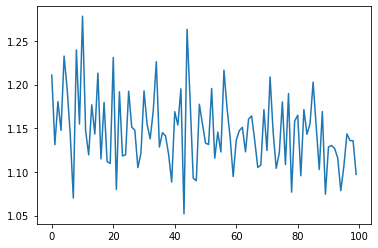

In [99]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)



To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




***Loading our saved model....***

In [75]:
rnn = torch.load('Surname_classification.pt')

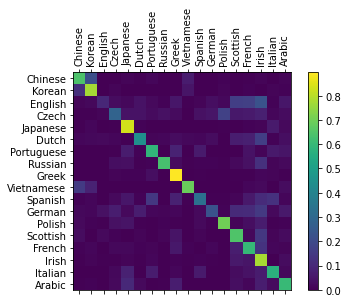

In [67]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




# Making predictions on our own data

***Loading saved model(I always prefer this thing to be done only after saving the model)***

In [91]:
rnn = torch.load('Surname_classification.pt')

***Defining some important function for predicition***

In [92]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [93]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [94]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.47) Russian
(-1.10) Czech
(-4.00) English

> Jackson
(-0.20) Scottish
(-2.65) English
(-3.44) Greek

> Satoshi
(-1.21) Arabic
(-1.46) Japanese
(-2.03) Polish


In [95]:
predict("Son")


> Son
(-0.08) Korean
(-3.02) Chinese
(-4.72) Vietnamese


# ***My_encoder***

In [19]:
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
       
    def forward(self, images):
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)
        return out



In [20]:
enc= Encoder()

*getting a test image*

In [3]:
!wget "https://resize.indiatvnews.com/en/resize/newbucket/715_-/2020/08/ram-mandir-image-1596552261.jpg"

--2020-09-02 07:43:47--  https://resize.indiatvnews.com/en/resize/newbucket/715_-/2020/08/ram-mandir-image-1596552261.jpg
Resolving resize.indiatvnews.com (resize.indiatvnews.com)... 13.226.45.46, 13.226.45.31, 13.226.45.116, ...
Connecting to resize.indiatvnews.com (resize.indiatvnews.com)|13.226.45.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29248 (29K) [image/jpeg]
Saving to: ‘ram-mandir-image-1596552261.jpg’

ram-mandir-image-15 100%[===================>]  28.56K   135KB/s    in 0.2s    

2020-09-02 07:43:48 (135 KB/s) - ‘ram-mandir-image-1596552261.jpg’ saved [29248/29248]



In [5]:
from PIL import Image
from torchvision.transforms import ToTensor

img_path="test.jpg"
image = Image.open(img_path)
image = ToTensor()(image).unsqueeze(0) # unsqueeze to add artificial first dimension

In [6]:
image.size()

torch.Size([1, 3, 402, 715])

In [24]:
image

tensor([[[[0.9882, 0.9882, 0.9882,  ..., 0.9804, 0.9804, 0.9804],
          [0.9882, 0.9882, 0.9882,  ..., 0.9804, 0.9804, 0.9804],
          [0.9882, 0.9882, 0.9882,  ..., 0.9804, 0.9804, 0.9804],
          ...,
          [0.5608, 0.5569, 0.5529,  ..., 0.3961, 0.4039, 0.4157],
          [0.5490, 0.5412, 0.5294,  ..., 0.4000, 0.4039, 0.4118],
          [0.5490, 0.5412, 0.5294,  ..., 0.4000, 0.4039, 0.4118]],

         [[0.7216, 0.7216, 0.7216,  ..., 0.8039, 0.8039, 0.8039],
          [0.7216, 0.7216, 0.7216,  ..., 0.8039, 0.8039, 0.8039],
          [0.7216, 0.7216, 0.7216,  ..., 0.8039, 0.8039, 0.8039],
          ...,
          [0.5412, 0.5373, 0.5333,  ..., 0.4667, 0.4745, 0.4863],
          [0.5176, 0.5098, 0.4980,  ..., 0.4549, 0.4588, 0.4667],
          [0.5176, 0.5098, 0.4980,  ..., 0.4549, 0.4588, 0.4667]],

         [[0.2235, 0.2235, 0.2235,  ..., 0.4392, 0.4392, 0.4392],
          [0.2235, 0.2235, 0.2235,  ..., 0.4392, 0.4392, 0.4392],
          [0.2235, 0.2235, 0.2235,  ..., 0

In [21]:
encoded_image = enc.forward(image)

In [22]:
encoded_image.size()

torch.Size([1, 14, 14, 2048])

In [23]:
encoded_image

tensor([[[[0.4973, 0.0000, 0.0000,  ..., 0.8600, 0.0000, 0.0000],
          [0.3024, 0.0000, 0.0000,  ..., 0.3686, 0.0000, 0.3058],
          [0.0067, 0.0000, 0.0000,  ..., 0.0286, 0.0000, 0.7529],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1552, 0.1624, 0.1460],
          [0.0000, 0.0242, 0.0000,  ..., 0.4886, 0.0783, 0.4642],
          [0.0000, 0.1491, 0.0000,  ..., 0.6108, 0.1174, 0.9352]],

         [[0.2486, 0.0000, 0.0000,  ..., 0.8989, 0.0233, 0.0000],
          [0.1542, 0.0000, 0.0172,  ..., 0.4018, 0.0000, 0.3500],
          [0.0034, 0.0000, 0.0053,  ..., 0.0396, 0.0000, 0.7406],
          ...,
          [0.0000, 0.0629, 0.1398,  ..., 0.0857, 0.0812, 0.1570],
          [0.0000, 0.1933, 0.2254,  ..., 0.7074, 0.0543, 0.3649],
          [0.0000, 0.2226, 0.0000,  ..., 1.2293, 0.0815, 0.8860]],

         [[0.0000, 0.0000, 0.5803,  ..., 0.7812, 0.0233, 0.0000],
          [0.0030, 0.0000, 0.5753,  ..., 0.3873, 0.0000, 0.3411],
          [0.0000, 0.0000, 0.1867,  ..., 0